# 1. Aquisição dos Dados

In [5]:
import pandas as pd

data = pd.read_csv("data.csv")
data.drop(columns=["Unnamed: 0"], inplace=True)

data.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


# 2. Pré-processamento dos dados

Ordenamento da tabela para simular situação em que os dados vêm juntos, ou seja, no momento de treinar, caso não seja bem misturado os dados serão todas de uma única classe (y)

In [6]:
dados_azar = data.sort_values("vendido", ascending=True)

x = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y = dados_azar["vendido"]

dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


# 3. Cross Validate

In [7]:
from sklearn.model_selection import cross_validate

In [8]:
def print_result(results):
    media = results["test_score"].mean()
    desvio_padrao = results["test_score"].std()
    
    print(f"Accuracy médio {media*100:.2f} | {(media - 2 * desvio_padrao)*100:.2F}% - {(media + 2 * desvio_padrao)*100:.2F}%")

#### Dummy Classifier (baseline)

In [9]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
results = cross_validate(dummy, x, y, cv = 10, return_train_score=False)

print_result(results)

Accuracy médio 58.00 | 58.00% - 58.00%


#### Decision Tree Classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth=2)
results = cross_validate(decision_tree, x, y, cv = 10, return_train_score=False)

print_result(results)

Accuracy médio 75.78 | 73.83% - 77.73%


#### Adiciona coluna "Modelo"

Gerando dados aleatórios de MODELO de carro para simulação de agrupamento ao usar nosso estimador


In [11]:
import numpy as np

data['modelo'] = data.idade_do_modelo + np.random.randint(-2, 3, size=10000)
data.modelo = data.modelo + abs(data.modelo.min()) + 1

data.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,20
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,4
4,117384.68,1,4,12770.11290,4


# 4. Entendendo HIPER PARÂMETROS

Análise de desempenho da pipeline de Decision Tree com base no MAX_DEPTH

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
from sklearn.tree import export_graphviz
import graphviz

### MAX_DEPTH = 2

Accuracy médio 75.78 | 73.71% - 77.86%


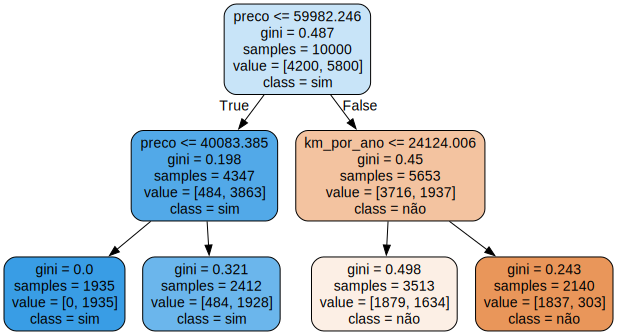

In [13]:
pipeline = Pipeline([('classifier', DecisionTreeClassifier(max_depth=2))])

results = cross_validate(pipeline, x, y, cv = GroupKFold(n_splits=10), groups = data.modelo, return_train_score=False)
print_result(results)

pipeline.fit(x, y)
features = x.columns    
graph_data = export_graphviz(pipeline["classifier"], out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)

graph = graphviz.Source(graph_data)
graph

### MAX_DEPTH = 3

Accuracy médio 78.69 | 76.89% - 80.48%


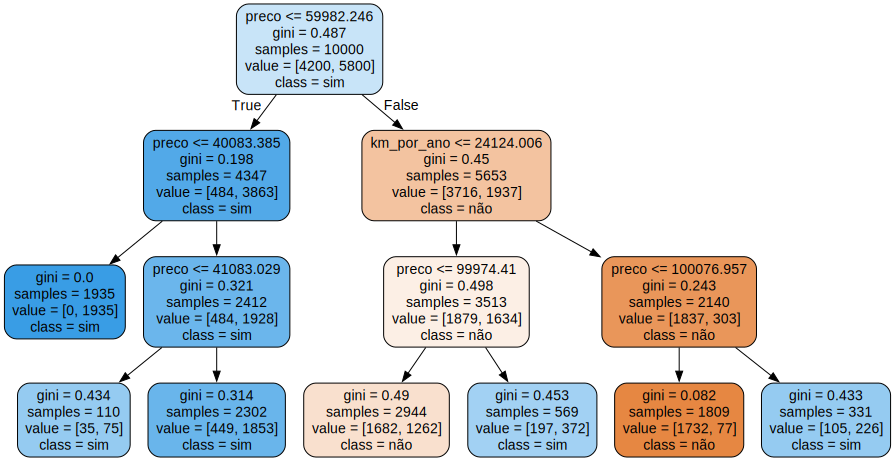

In [14]:
pipeline = Pipeline([('classifier', DecisionTreeClassifier(max_depth=3))])

results = cross_validate(pipeline, x, y, cv = GroupKFold(n_splits=10), groups = data.modelo, return_train_score=False)
print_result(results)

pipeline.fit(x, y)
features = x.columns    
graph_data = export_graphviz(pipeline["classifier"], out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)

graph = graphviz.Source(graph_data)
graph

### MAX_DEPTH = 10

Accuracy médio 76.83 | 75.04% - 78.61%


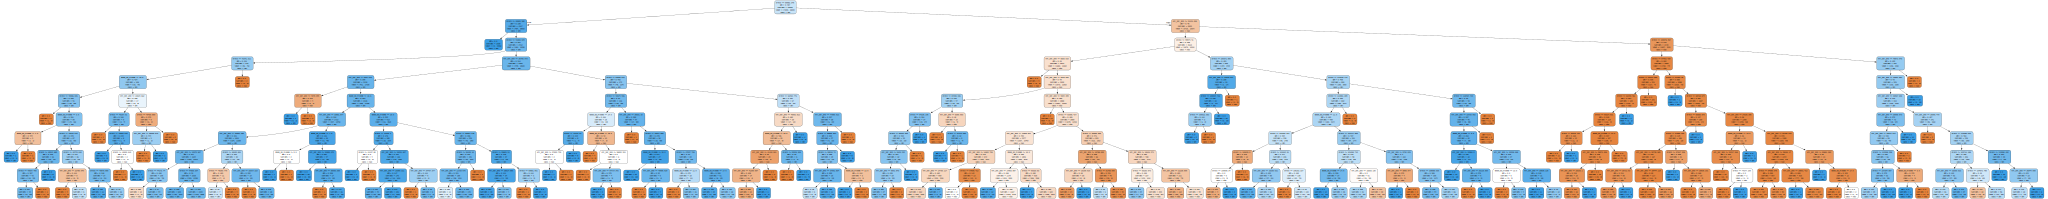

In [15]:
pipeline = Pipeline([('classifier', DecisionTreeClassifier(max_depth=10))])

results = cross_validate(pipeline, x, y, cv = GroupKFold(n_splits=10), groups = data.modelo, return_train_score=False)
print_result(results)

pipeline.fit(x, y)
features = x.columns    
graph_data = export_graphviz(pipeline["classifier"], out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)

graph = graphviz.Source(graph_data)
graph

#### Conclusão: NÃO HÁ RELAÇÃO LINEAR DE ENTRE AUMENTO DE PROFUNDIDADE E PRECISÃO.

# 5. Explorando HIPER PARÂMETROS manualmente

Buscando formas de encontrar o valor IDEAL para os HIPER PARÂMETROS

## Explorando HIPER PARÂMETROS em uma dimensão

In [16]:
def roda_pipeline_1d(max_depth):
  pipeline = Pipeline([('classifier', DecisionTreeClassifier(max_depth=max_depth))])
  results = cross_validate(pipeline, x, y, cv = GroupKFold(n_splits=10), groups = data.modelo, return_train_score=True)

  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  tabela = [max_depth, train_score, test_score]
  return tabela

In [17]:
import seaborn as sns

tabela = [roda_pipeline_1d(i) for i in range(1, 33)]
tabela = pd.DataFrame(tabela, columns=["max_depth", "train", "test"])

tabela.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.756714,78.685098
3,4,78.788945,78.675138
4,5,78.916596,78.463343
5,6,79.165703,78.390330
6,7,79.445850,78.259162


#### Exibindo Gráfico e o conceito de UNDERFIT e OVERFIT

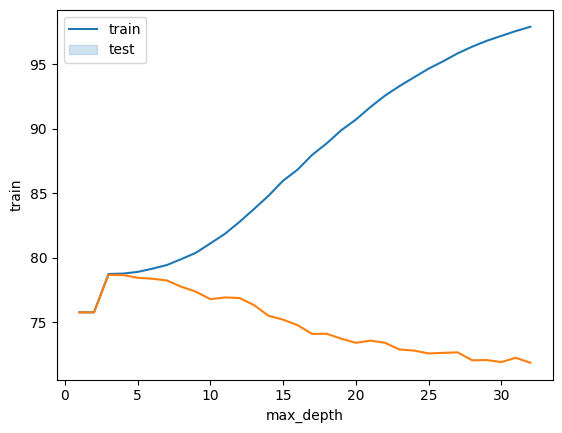

In [18]:
import matplotlib.pyplot as plt

sns.lineplot(x="max_depth", y="train", data=tabela)
sns.lineplot(x="max_depth", y="test", data=tabela)

plt.legend(["train", "test"])

## Explorando HIPER PARÂMETROS em duas dimensões

In [19]:
def roda_pipeline_2d(max_depth, min_samples_leaf):

  pipeline = Pipeline([('classifier', DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf))])
  results = cross_validate(pipeline, x, y, cv = GroupKFold(n_splits=10), groups = data.modelo, return_train_score=True)
  
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, train_score, test_score]

  return tabela

def busca_2d():
  resultados = []
  
  for max_depth in range(1,33):  
    for min_samples_leaf in [32, 64, 128, 256]:
      tabela = roda_pipeline_2d(max_depth, min_samples_leaf)
      resultados.append(tabela)

  resultados = pd.DataFrame(resultados, columns=["max_depth", "min_samples_leaf", "train", "test"])

  return resultados

In [20]:
tabela = busca_2d()
tabela.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
12,4,32,78.751171,78.695515
14,4,128,78.751171,78.695515
8,3,32,78.751171,78.695515
9,3,64,78.751171,78.695515
10,3,128,78.751171,78.695515


### Análises Gráficas

#### Correlação

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.535633,0.054103
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.408600,0.492952
train,5.356326e-01,-4.086002e-01,1.000000,0.118281
test,5.410321e-02,4.929519e-01,0.118281,1.000000


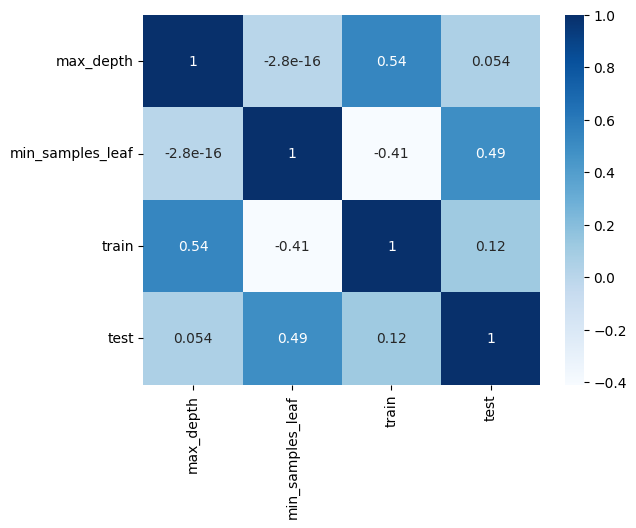

In [21]:
corr = tabela.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

corr

#### Scatter_Matrix

array([[<Axes: xlabel='max_depth', ylabel='max_depth'>,
        <Axes: xlabel='min_samples_leaf', ylabel='max_depth'>,
        <Axes: xlabel='train', ylabel='max_depth'>,
        <Axes: xlabel='test', ylabel='max_depth'>],
       [<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <Axes: xlabel='train', ylabel='min_samples_leaf'>,
        <Axes: xlabel='test', ylabel='min_samples_leaf'>],
       [<Axes: xlabel='max_depth', ylabel='train'>,
        <Axes: xlabel='min_samples_leaf', ylabel='train'>,
        <Axes: xlabel='train', ylabel='train'>,
        <Axes: xlabel='test', ylabel='train'>],
       [<Axes: xlabel='max_depth', ylabel='test'>,
        <Axes: xlabel='min_samples_leaf', ylabel='test'>,
        <Axes: xlabel='train', ylabel='test'>,
        <Axes: xlabel='test', ylabel='test'>]], dtype=object)

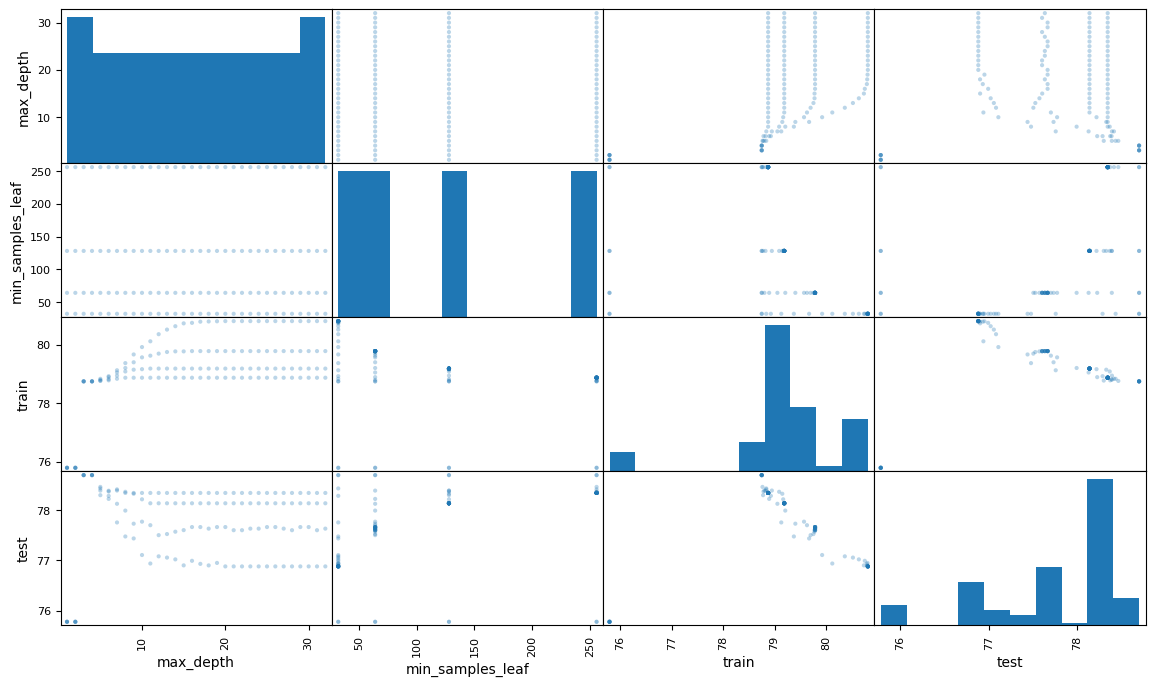

In [22]:
pd.plotting.scatter_matrix(tabela, figsize = (14, 8), alpha = 0.3)

#### Pairplot

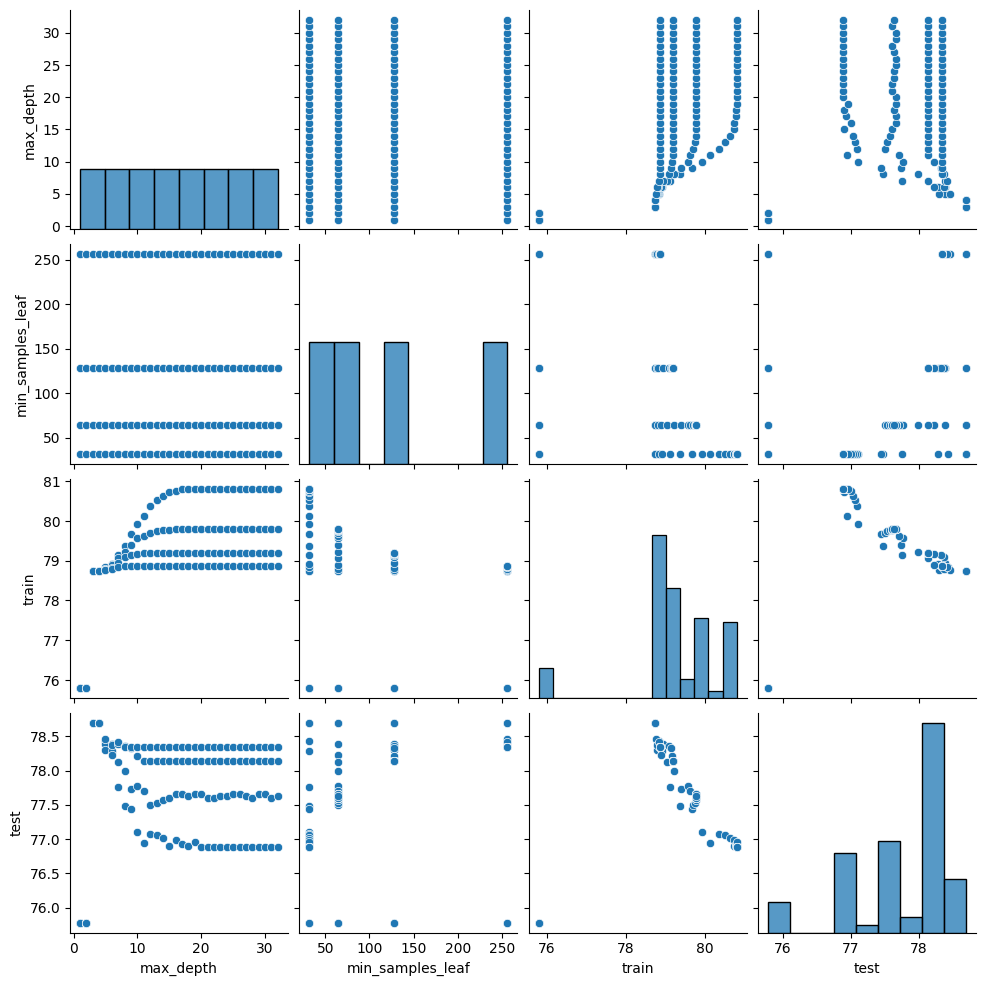

In [23]:
sns.pairplot(tabela)

<Axes: >

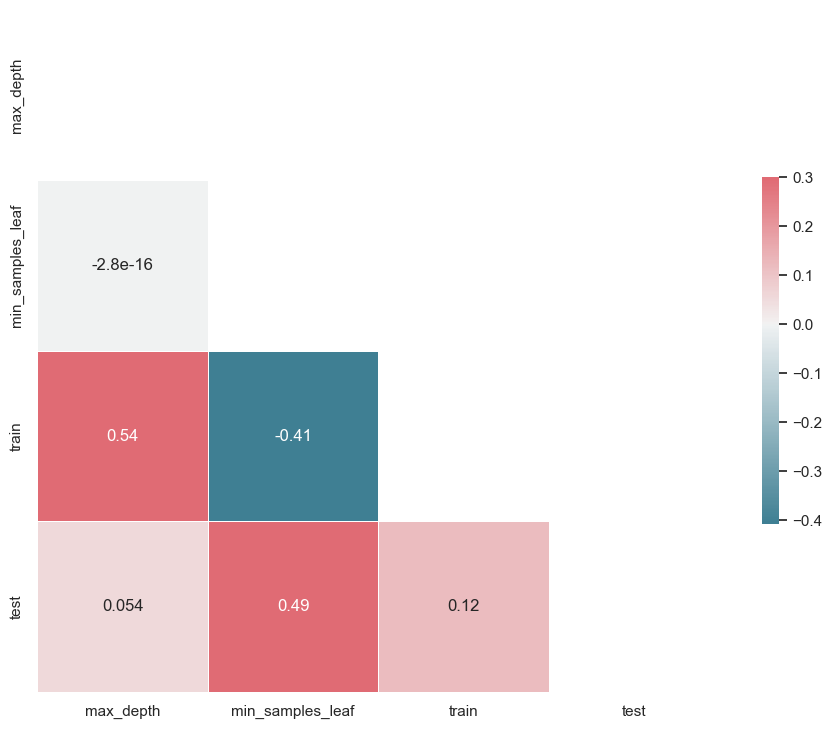

In [24]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

## Explorando HIPER PARÂMETROS em três dimensões

In [25]:
def roda_pipeline_3d(max_depth, min_samples_leaf, min_samples_split):
  
  pipeline = Pipeline([('classifier', DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split))])
  results = cross_validate(pipeline, x, y, cv = GroupKFold(n_splits=10), groups = data.modelo, return_train_score=True)

  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  
  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  
  return tabela

def busca_3d():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_pipeline_3d(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)

  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","min_samples_split","train","test","fit_time","score_time"])
  return resultados

In [26]:
tabela = busca_3d()
tabela.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
50,4,32,128,78.751171,78.695515,0.012355,0.001266
48,4,32,32,78.751171,78.695515,0.012627,0.001459
34,3,32,128,78.751171,78.695515,0.010130,0.001516
36,3,64,32,78.751171,78.695515,0.009990,0.001562
37,3,64,64,78.751171,78.695515,0.010009,0.001655


### Análise Gráfica

#### Correlação

<Axes: >

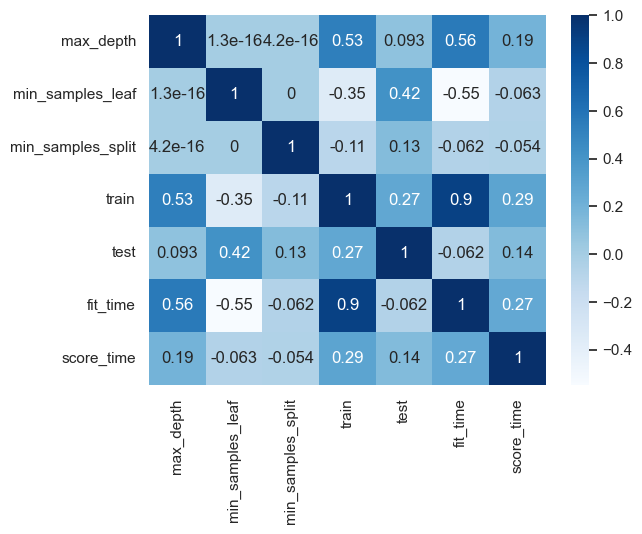

In [27]:
corr = tabela.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

#### Correlação Diagonal

<Axes: >

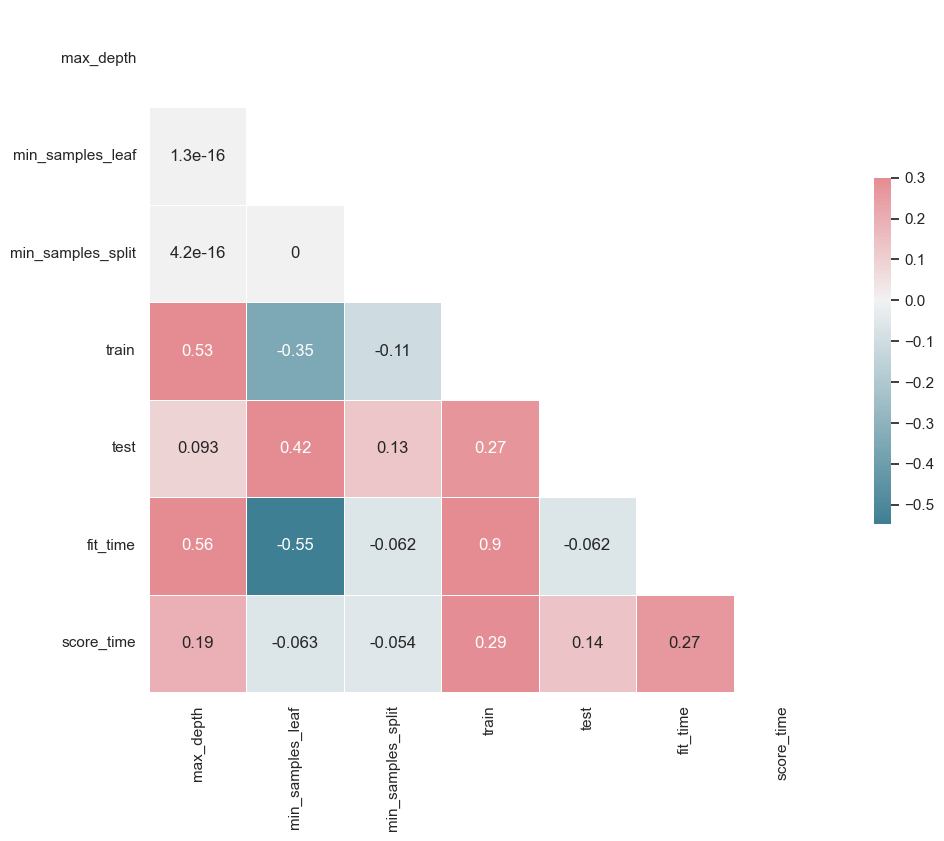

In [28]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# 6. Explorando  HIPER PARÂMETROS com GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

tree_params = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

In [29]:
grid_search = GridSearchCV(DecisionTreeClassifier(), tree_params, cv = KFold(n_splits = 10))
grid_search.fit(x, y, groups = data.modelo)

resultados = pd.DataFrame(grid_search.cv_results_).sort_values("mean_test_score", ascending=False)

print(f"Melhor resultado: {grid_search.best_score_} com {grid_search.best_params_}")

Melhor resultado: 0.7867000000000001 com {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010549,0.000369,0.001590,0.000573,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.831,...,0.805,0.774,0.768,0.755,0.776,0.774,0.771,0.7867,0.022681,1
1,0.010133,0.000456,0.001259,0.000306,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.831,...,0.805,0.774,0.768,0.755,0.776,0.774,0.771,0.7867,0.022681,1
26,0.011754,0.000473,0.001214,0.000310,entropy,3,128,128,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.831,...,0.805,0.774,0.768,0.755,0.776,0.774,0.771,0.7867,0.022681,1
25,0.011783,0.000560,0.001192,0.000364,entropy,3,128,64,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.831,...,0.805,0.774,0.768,0.755,0.776,0.774,0.771,0.7867,0.022681,1
24,0.011630,0.000481,0.001251,0.000502,entropy,3,128,32,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.831,...,0.805,0.774,0.768,0.755,0.776,0.774,0.771,0.7867,0.022681,1


## Validação do modelo pós otimização dos HIPER PARÂMETROS

### Accuracy_score

Deve ser evitada pois estará sendo muito otimista.

In [31]:
from sklearn.metrics import accuracy_score

best = grid_search.best_estimator_

predicoes = best.predict(x)
accuracy = accuracy_score(predicoes, y) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


### Nested Cross Validation

No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada para evitar que tenhamos uma estimativa com vício nos dados já vistos. Chama-se nested cross validation.

Nested Cross Validation não supor usar Grid com GroupKFold, bug.

In [32]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(grid_search, x, y, cv = KFold(n_splits=10, shuffle=True))

media = scores.mean()
desvio_padrao = scores.std()

best = grid_search.best_estimator_


print(best)
print(f"Accuracy médio {media*100:.2f} | {(media - 2 * desvio_padrao)*100:.2F}% - {(media + 2 * desvio_padrao)*100:.2F}%")

Accuracy médio 78.66 | 75.28% - 82.04%


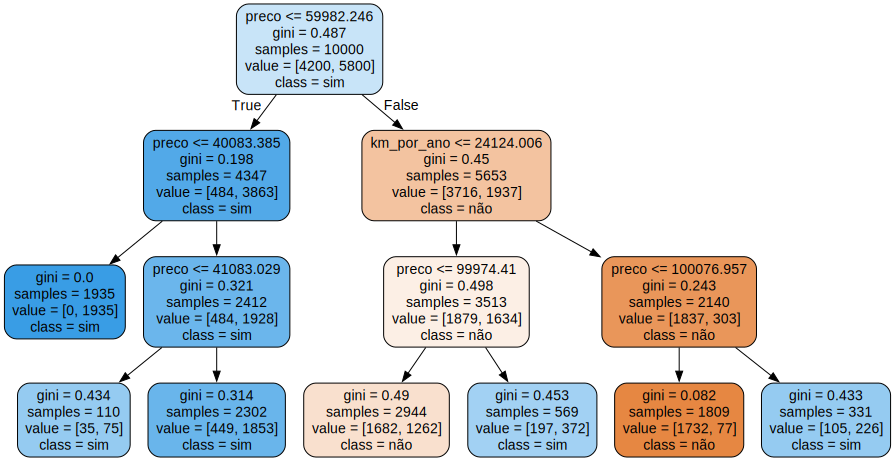

In [34]:
features = x.columns
graph_data = export_graphviz(best, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)

graph = graphviz.Source(graph_data)
graph

# 7. Explorando  HIPER PARÂMETROS com RandomizedSearchCV

Enquanto um GridSearchCV passa por todos os valores no grid (image como um plano cartesiano), o RandomizedSearchCV escolhe um número (definido) de elementos que ele vai, aleatóriamente, escolher. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


tree_params = {
    "max_depth" : [3, 5, 10, 15, 20, 30],
    "min_samples_split" : randint(32, 128),
    "min_samples_leaf" : randint(32, 128),
    "criterion" : ["gini", "entropy"]
}

In [41]:
randomized_search = RandomizedSearchCV(DecisionTreeClassifier(), tree_params, n_iter=64, cv = KFold(n_splits = 10))
randomized_search.fit(x, y, groups = data.modelo)

resultados = pd.DataFrame(randomized_search.cv_results_).sort_values("mean_test_score", ascending=False)
print(f"Melhor resultado: {randomized_search.best_score_} com {randomized_search.best_params_}")

Melhor resultado: 0.7867000000000001 com {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 80, 'min_samples_split': 88}


In [38]:
scores = cross_val_score(randomized_search, x, y, cv = KFold(n_splits=10, shuffle=True))

media = scores.mean()
desvio_padrao = scores.std()

best = randomized_search.best_estimator_

print(f"{best}")
print(f"Accuracy médio {media*100:.2f} | {(media - 2 * desvio_padrao)*100:.2F}% - {(media + 2 * desvio_padrao)*100:.2F}%")

Accuracy médio 78.69 | 77.52% - 79.86%


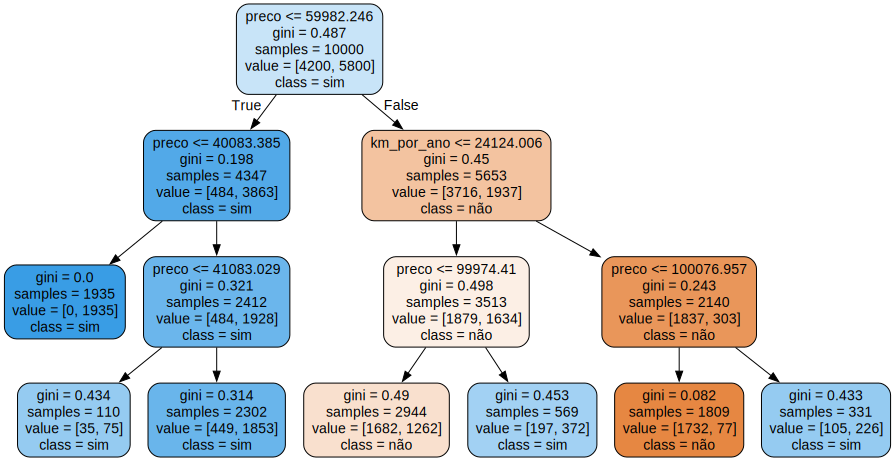

In [40]:
features = x.columns
graph_data = export_graphviz(best, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names = features)

graph = graphviz.Source(graph_data)
graph


# 8. Comparação GridSearchCV e RandomizedSearchCV

Comparação, principalmente, do tempo de execução de ambos

In [43]:
import time
from sklearn.ensemble import RandomForestClassifier

tree_params = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

## GridSearchCV

Treino

In [44]:
start = time.time()
grid_search = GridSearchCV(RandomForestClassifier(), tree_params, cv = KFold(n_splits = 10, shuffle=True))
grid_search.fit(x, y, groups = data.modelo)
end = time.time()

print(f"Tempo de execução: {end - start}")

Tempo de execução: 380.2591509819031


In [46]:
resultados = pd.DataFrame(grid_search.cv_results_).sort_values("mean_test_score", ascending=False)

for i, line in resultados.head().iterrows():
    print(f"{line.mean_test_score} +/- {line.std_test_score:.5f} - {line.params}")

0.781 +/- 0.01244 - {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.7806000000000001 +/- 0.01038 - {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.7803 +/- 0.01000 - {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 128, 'min_samples_split': 32, 'n_estimators': 10}
0.7802 +/- 0.00797 - {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.7792000000000001 +/- 0.00838 - {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 128, 'n_estimators': 10}


Validação

In [47]:
start = time.time()
scores = cross_val_score(grid_search, x, y, cv = KFold(n_splits=10, shuffle=True))
end = time.time()

print(f"Tempo de execução: {end - start}")

media = scores.mean()
desvio_padrao = scores.std()

print(f"Accuracy médio {media*100:.2f} | {(media - 2 * desvio_padrao)*100:.2F}% - {(media + 2 * desvio_padrao)*100:.2F}%")

KeyboardInterrupt: 

## RandomizedSearchCV

Treino

In [48]:
start = time.time()
randomized_search = RandomizedSearchCV(RandomForestClassifier(), tree_params, n_iter=64, cv = KFold(n_splits = 10, shuffle=True))
randomized_search.fit(x, y, groups = data.modelo)
end = time.time()

print(f"Tempo de execução: {end - start}")

Tempo de execução: 150.84880256652832


In [50]:
resultados = pd.DataFrame(randomized_search.cv_results_).sort_values("mean_test_score", ascending=False)

for i, line in resultados.head().iterrows():
    print(f"{line.mean_test_score:.6f} +/- {line.std_test_score:.4f} - {line.params}")

0.779000 +/- 0.0138 - {'n_estimators': 10, 'min_samples_split': 128, 'min_samples_leaf': 128, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}
0.777700 +/- 0.0139 - {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.777600 +/- 0.0148 - {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}
0.777400 +/- 0.0149 - {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}
0.777400 +/- 0.0152 - {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}


Validação

In [51]:
scores = cross_val_score(randomized_search, x, y, cv = KFold(n_splits=10, shuffle=True))

media = scores.mean()
desvio_padrao = scores.std()

print(f"Accuracy médio {media*100:.2f} | {(media - 2 * desvio_padrao)*100:.2F}% - {(media + 2 * desvio_padrao)*100:.2F}%")

KeyboardInterrupt: 

# 9. Validação sem Cross-Validation

Para situações onde não é possível usar o CV, alta demanda computacional, por exemplo

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

params = {
    "n_estimators" :randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

In [ ]:
x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x, y, test_size = 0.2, stratify = y)


start = time.time()
randomized_search = RandomizedSearchCV(RandomForestClassifier(), params, n_iter=64, cv = StratifiedShuffleSplit(n_splits=1, test_size=0.25))
randomized_search.fit(x_treino_teste, y_treino_teste)
end = time.time()

print(f"Tempo de execução: {end - start}")

In [ ]:
start = time.time()
scores = cross_val_score(randomized_search, x_validacao, y_validacao, cv = StratifiedShuffleSplit(n_splits=1, test_size=0.25))
end = time.time()

media = scores.mean()

print(f"Tempo de execução: {end - start}")
print(f"Accuracy médio {media*100:.2f} | {(media - 2 * desvio_padrao)*100:.2F}% - {(media + 2 * desvio_padrao)*100:.2F}%")